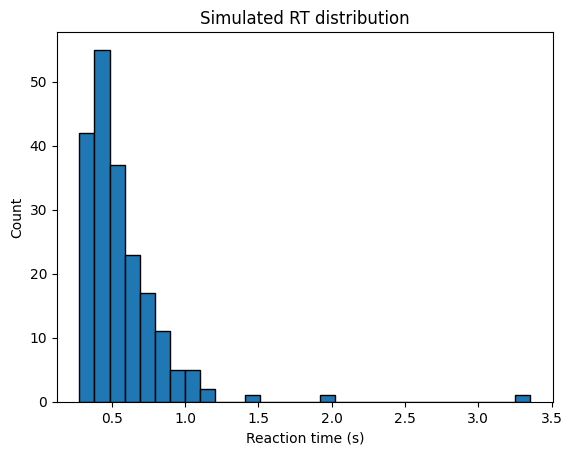

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate RT data (seconds)
np.random.seed(0)
true_muR = 3.0     # true mean rate
true_deltaS = 1.5  # true threshold

# Compute corresponding mu and sigma for 1/RT
mu = true_muR / true_deltaS
sigma = 1 / true_deltaS

# Simulate reciprocal RTs as Gaussian, then invert to get RTs
inv_RTs = np.random.normal(mu, sigma, size=200)
RTs = 1 / inv_RTs

plt.hist(RTs, bins=30, edgecolor='k')
plt.xlabel("Reaction time (s)")
plt.ylabel("Count")
plt.title("Simulated RT distribution")
plt.show()

In [3]:
from scipy.stats import norm

def later_nll(fits, RTs):
    muR, deltaS = fits
    if muR <= 0 or deltaS <= 0:
        return np.inf  # enforce positivity constraint

    inv_RTs = 1 / RTs
    mu = muR / deltaS
    sigma = 1 / deltaS

    log_likelihoods = norm.logpdf(inv_RTs, loc=mu, scale=sigma)
    nll = -np.sum(log_likelihoods)
    return nll

In [9]:
from scipy.optimize import minimize

# Define bounds [(lower_muR, upper_muR), (lower_deltaS, upper_deltaS)]
bounds = [(1e-3, 1000), (1e-3, 1000)]

# Initial values based on rough empirical estimates
initial_muR = 1 / np.mean(RTs)  # reciprocal of mean RT
initial_deltaS = 1 / np.std(1/RTs)
initial_values = [initial_muR, initial_deltaS]

print(f"Initial values: muR = {initial_muR:.3f}, deltaS = {initial_deltaS:.3f}")

Initial values: muR = 1.765, deltaS = 1.469


In [7]:
best_fit = None
best_nll = np.inf

for i in range(20):  # 20 random restarts
    x0 = np.array(initial_values) * np.random.uniform(0.8, 1.2, 2)
    result = minimize(later_nll, x0, args=(RTs,), bounds=bounds, method='L-BFGS-B')
    if result.fun < best_nll:
        best_nll = result.fun
        best_fit = result.x

print(f"Best fit parameters: muR = {best_fit[0]:.3f}, deltaS = {best_fit[1]:.3f}")
print(f"Negative log-likelihood: {best_nll:.3f}")

Best fit parameters: muR = 3.007, deltaS = 1.469
Negative log-likelihood: 206.934


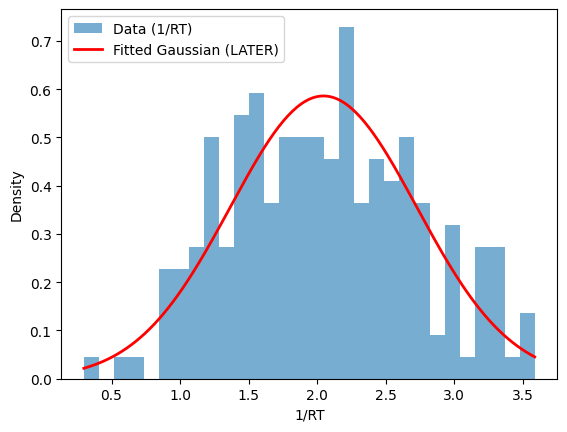

In [8]:
inv_RTs = 1 / RTs
fitted_mu = best_fit[0] / best_fit[1]
fitted_sigma = 1 / best_fit[1]

x = np.linspace(min(inv_RTs), max(inv_RTs), 200)
pdf = norm.pdf(x, fitted_mu, fitted_sigma)

plt.hist(inv_RTs, bins=30, density=True, alpha=0.6, label="Data (1/RT)")
plt.plot(x, pdf, 'r-', lw=2, label="Fitted Gaussian (LATER)")
plt.xlabel("1/RT")
plt.ylabel("Density")
plt.legend()
plt.show()